In [1]:
import visual_behavior.database as db
import visual_behavior.utilities as vbu
from visual_behavior.data_access import loading
from visual_behavior.translator.foraging2 import data_to_change_detection_core
import seaborn as sns
from scipy import signal
from scipy.signal import medfilt
import visual_behavior.encoder_processing.utilities as encoder_utilities
from visual_behavior.encoder_processing.spline_regression import spline_regression

import allensdk.brain_observatory.behavior.running_processing as rp

/home/dougo/Code/AllenSDK/allensdk/brain_observatory/behavior/behavior_ophys_api/behavior_ophys_nwb_api.py:9: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
%widescreen
%matplotlib notebook

In [3]:
bsid = 938991494
running_df = encoder_utilities.load_running_df(bsid).query('time>=1500 and time <= 1600')
running_df['time'].iloc[:10]

89925    1500.002134
89926    1500.018831
89927    1500.035523
89928    1500.052175
89929    1500.068870
89930    1500.085568
89931    1500.102219
89932    1500.118927
89933    1500.135609
89934    1500.152260
Name: time, dtype: float64

In [4]:
len(running_df['time'].values)

5995

In [5]:
running_df = encoder_utilities.add_speed_acceleration_jerk(running_df, column_label='raw',v_max='v_sig_max')

In [6]:
b, a = signal.butter(3, 0.2)
running_df['speed_butterworth'] = signal.filtfilt(b, a, running_df['speed_raw'].fillna(0))

In [7]:
running_df

,time,frame,speed,dx,v_sig,v_in,v_sig_last,wrap_ID,v_sig_diff,v_sig_unwrapped,speed_raw,wrap_bool,acceleration_raw,jerk_raw,speed_butterworth
89925,1500.002134,89925,29.181382,4.834713,1.879013,4.993889,NaN,0,NaN,NaN,NaN,False,NaN,NaN,0.013839
89926,1500.018831,89926,28.480019,5.065577,1.948778,4.992597,1.879013,0,0.069765,1.948778,NaN,False,NaN,NaN,6.602830
89927,1500.035523,89927,28.520210,5.816679,2.026295,4.984845,1.948778,0,0.077517,2.026295,NaN,False,NaN,NaN,13.141574
89928,1500.052175,89928,28.410312,4.797609,2.092184,4.983553,2.026295,0,0.065889,2.092184,27.455471,False,NaN,NaN,19.341870
89929,1500.068870,89929,27.598898,4.625966,2.156781,4.984845,2.092184,0,0.064597,2.156781,26.838475,False,-36.954971,NaN,24.699387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95915,1599.918901,95915,40.293086,6.992374,2.541780,4.984845,2.448760,0,0.093020,382.872163,38.681974,False,7.411401,54896.282397,42.923770
95916,1599.935557,95916,40.515842,9.143667,2.668391,4.984845,2.541780,0,0.126610,382.998773,52.729076,False,843.360523,50188.752431,43.853394
95917,1599.952262,95917,40.738173,6.822318,2.767870,4.993889,2.668391,0,0.099480,383.098253,41.234726,False,-688.091904,-91678.091726,45.484681
95918,1599.968942,95918,40.053412,7.079789,2.860890,4.984845,2.767870,0,0.093020,383.191273,38.683331,False,-152.957757,32081.636205,47.812526


In [18]:
cached_res_dir = '/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/smoothed_running_data'
cached_df = pd.read_csv(os.path.join(cached_res_dir, 'running_data_behavior_session_id={}_1000_2000_1.csv'.format(bsid)))
cols_to_merge = ['time'] + [col for col in cached_df.columns if 'spline_smoothed' in col]
running_df = pd.merge_asof(
    running_df,
    cached_df[cols_to_merge],
    left_on='time',
    right_on='time',
    direction='nearest'
)


In [24]:
cached_df_2 = pd.read_csv(os.path.join(cached_res_dir, 'running_data_behavior_session_id={}.csv'.format(bsid)))

<IPython.core.display.Javascript object>


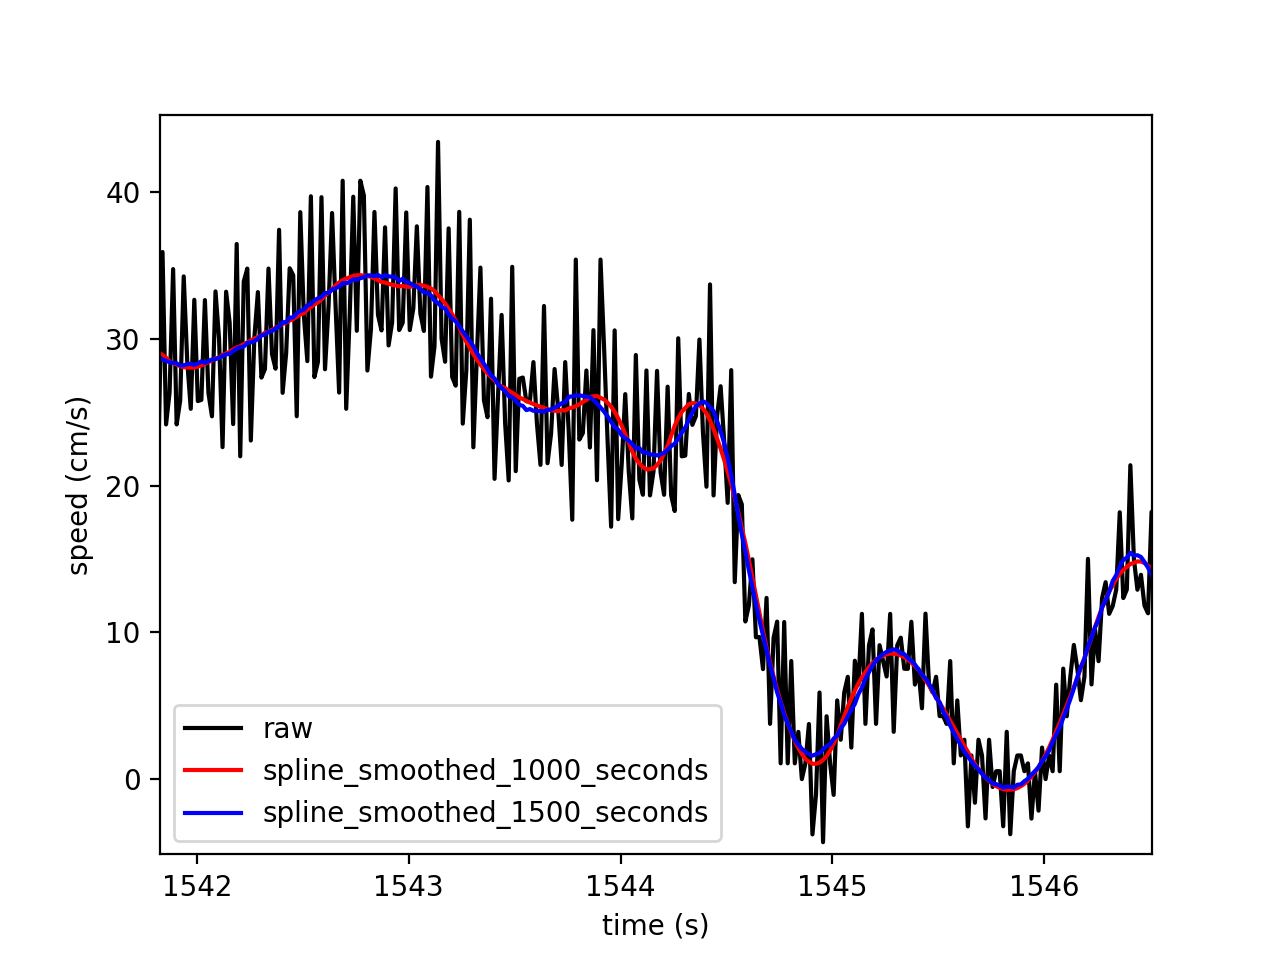

In [26]:
fig,ax=plt.subplots()
ax.plot(running_df['time'], running_df['speed_raw'],color='black')
ax.plot(cached_df['time'], cached_df['speed_spline_smoothed_F=12'],color='red')
ax.plot(cached_df_2['time'], cached_df_2['speed_spline_smoothed_F=12'],color='blue')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (cm/s)')
ax.legend(['raw','spline_smoothed_1000_seconds','spline_smoothed_1500_seconds'])

In [9]:
running_df

,time,frame,speed,dx,v_sig,v_in,v_sig_last,wrap_ID,v_sig_diff,v_sig_unwrapped,speed_raw,wrap_bool,acceleration_raw,jerk_raw,speed_butterworth,v_spline_smoothed_F=12,speed_spline_smoothed_F=12,acceleration_spline_smoothed_F=12,jerk_spline_smoothed_F=12
0,1500.002134,89925,29.181382,4.834713,1.879013,4.993889,NaN,0,NaN,NaN,NaN,False,NaN,NaN,0.013839,2150.206279,30.885441,7.458521,37.906385
1,1500.018831,89926,28.480019,5.065577,1.948778,4.992597,1.879013,0,0.069765,1.948778,NaN,False,NaN,NaN,6.602830,2150.281003,30.995076,6.566001,-53.452762
2,1500.035523,89927,28.520210,5.816679,2.026295,4.984845,1.948778,0,0.077517,2.026295,NaN,False,NaN,NaN,13.141574,2150.356023,31.175927,10.834552,255.722949
3,1500.052175,89928,28.410312,4.797609,2.092184,4.983553,2.026295,0,0.065889,2.092184,27.455471,False,NaN,NaN,19.341870,2150.431184,31.318983,8.591202,-134.724186
4,1500.068870,89929,27.598898,4.625966,2.156781,4.984845,2.092184,0,0.064597,2.156781,26.838475,False,-36.954971,NaN,24.699387,2150.506806,31.419241,6.004936,-154.904353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5990,1599.918901,95915,40.293086,6.992374,2.541780,4.984845,2.448760,0,0.093020,382.872163,38.681974,False,7.411401,54896.282397,42.923770,2531.420571,42.847484,-0.606341,41.049879
5991,1599.935557,95916,40.515842,9.143667,2.668391,4.984845,2.541780,0,0.126610,382.998773,52.729076,False,843.360523,50188.752431,43.853394,2531.523311,42.787540,-3.598932,-179.669316
5992,1599.952262,95917,40.738173,6.822318,2.767870,4.993889,2.668391,0,0.099480,383.098253,41.234726,False,-688.091904,-91678.091726,45.484681,2531.626412,42.736094,-3.079691,31.083573
5993,1599.968942,95918,40.053412,7.079789,2.860890,4.984845,2.767870,0,0.093020,383.191273,38.683331,False,-152.957757,32081.636205,47.812526,2531.729013,42.667346,-4.121495,-62.456822


In [10]:
def make_plot(df_in):
    fig,ax=plt.subplots(4,1,figsize=(15,10), sharex=True)
    ax[0].plot(
        df_in['time'],
        df_in['time'].diff(),
        color='black',
        marker='.'
    )
    
    ax[1].plot(
        df_in['time'],
        df_in['v_sig'],
        '-r',
        marker='.'
    )
    ax[1].plot(
        df_in['time'],
        df_in['v_in'],
        '-b'
    )
    ax[1].axhline(0)
    
    ax[2].plot(
        df_in['time'],
        df_in['v_sig_unwrapped'],
        marker='.'
    )
    
    ax[2].plot(
        df_in['time'],
        df_in['v_spline_smoothed_F=12']-df_in['v_spline_smoothed_F=12'].iloc[0],
        marker='.'
    )

    ax[3].plot(
        df_in['time'],
        df_in['speed_raw'],
        '-b'
    )

    ax[3].plot(
        df_in['time'],
        df_in['speed_butterworth'],
        color='black',
    )
    
    ax[3].plot(
        df_in['time'],
        df_in['speed_spline_smoothed_F=12'],
        color='orange',
        marker='o'
    )

#     for i in range(len(ax)):
#         for idx,row in df_in[running_df['wrap_ID']!=0].iterrows():
#             ax[i].axvline(row['time'],zorder=-np.inf,alpha=0.5)
            
    fig.tight_layout()
            
    return fig,ax


dft = running_df.query('time>=1000 and time <= 2000')
dft

,time,frame,speed,dx,v_sig,v_in,v_sig_last,wrap_ID,v_sig_diff,v_sig_unwrapped,speed_raw,wrap_bool,acceleration_raw,jerk_raw,speed_butterworth,v_spline_smoothed_F=12,speed_spline_smoothed_F=12,acceleration_spline_smoothed_F=12,jerk_spline_smoothed_F=12
0,1500.002134,89925,29.181382,4.834713,1.879013,4.993889,NaN,0,NaN,NaN,NaN,False,NaN,NaN,0.013839,2150.206279,30.885441,7.458521,37.906385
1,1500.018831,89926,28.480019,5.065577,1.948778,4.992597,1.879013,0,0.069765,1.948778,NaN,False,NaN,NaN,6.602830,2150.281003,30.995076,6.566001,-53.452762
2,1500.035523,89927,28.520210,5.816679,2.026295,4.984845,1.948778,0,0.077517,2.026295,NaN,False,NaN,NaN,13.141574,2150.356023,31.175927,10.834552,255.722949
3,1500.052175,89928,28.410312,4.797609,2.092184,4.983553,2.026295,0,0.065889,2.092184,27.455471,False,NaN,NaN,19.341870,2150.431184,31.318983,8.591202,-134.724186
4,1500.068870,89929,27.598898,4.625966,2.156781,4.984845,2.092184,0,0.064597,2.156781,26.838475,False,-36.954971,NaN,24.699387,2150.506806,31.419241,6.004936,-154.904353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5990,1599.918901,95915,40.293086,6.992374,2.541780,4.984845,2.448760,0,0.093020,382.872163,38.681974,False,7.411401,54896.282397,42.923770,2531.420571,42.847484,-0.606341,41.049879
5991,1599.935557,95916,40.515842,9.143667,2.668391,4.984845,2.541780,0,0.126610,382.998773,52.729076,False,843.360523,50188.752431,43.853394,2531.523311,42.787540,-3.598932,-179.669316
5992,1599.952262,95917,40.738173,6.822318,2.767870,4.993889,2.668391,0,0.099480,383.098253,41.234726,False,-688.091904,-91678.091726,45.484681,2531.626412,42.736094,-3.079691,31.083573
5993,1599.968942,95918,40.053412,7.079789,2.860890,4.984845,2.767870,0,0.093020,383.191273,38.683331,False,-152.957757,32081.636205,47.812526,2531.729013,42.667346,-4.121495,-62.456822


In [11]:
dft['time'].diff().describe()

count    5994.000000
mean        0.016681
std         0.000029
min         0.016601
25%         0.016656
50%         0.016681
75%         0.016705
max         0.016758
Name: time, dtype: float64

In [12]:
n_knot_factor = 12
n_knots = len(dft)/n_knot_factor
dft['v_spline_smoothed_F={}_recalc'.format(n_knot_factor)] = spline_regression(dft, col_to_smooth='v_sig_unwrapped', n_knots=n_knots)
dft['speed_spline_smoothed_F={}_recalc'.format(n_knot_factor)] = encoder_utilities.calculate_speed(dft, voltage_column='v_spline_smoothed_F={}_recalc'.format(n_knot_factor))

# df_in['v_spline_smoothed_F={}'.format(n_knot_factor)] = spline_regression(df_in, col_to_smooth='v_sig_unwrapped', n_knots=n_knots)
# df_in['speed_spline_smoothed_F={}'.format(n_knot_factor)] = calculate_speed(df_in, voltage_column='v_spline_smoothed_F={}'.format(n_knot_factor))

X is 5995 elements long
first 10 X values: [[1500.00213373]
 [1500.01883108]
 [1500.03552317]
 [1500.0521746 ]
 [1500.06887049]
 [1500.08556843]
 [1500.10221898]
 [1500.11892746]
 [1500.13560872]
 [1500.15225985]]
X[500:510]): [[1508.34246098]
 [1508.35910831]
 [1508.37581971]
 [1508.39249981]
 [1508.40913631]
 [1508.42586263]
 [1508.4425439 ]
 [1508.4591921 ]
 [1508.47590263]
 [1508.49258419]]
X[2000:2010]): [[1533.36329911]
 [1533.3799871 ]
 [1533.39671167]
 [1533.41334144]
 [1533.43008737]
 [1533.44674201]
 [1533.46338319]
 [1533.48007119]
 [1533.49679195]
 [1533.513458  ]]
X[-10:]): [[1599.83546501]
 [1599.85217787]
 [1599.86885943]
 [1599.88551144]
 [1599.90221992]
 [1599.91890089]
 [1599.935557  ]
 [1599.95226167]
 [1599.96894206]
 [1599.98559962]]
499 knots at [1500.20210066 1500.40206759 1500.60203452 1500.80200145 1501.00196838
 1501.20193532 1501.40190225 1501.60186918 1501.80183611 1502.00180304
 1502.20176997 1502.40173691 1502.60170384 1502.80167077 1503.0016377
 1503.2016

In [13]:
n_knot_factor=12
df_sr = encoder_utilities.apply_spline_regression(dft, n_knot_factor)

applying spline regression to dataset with 5995 datapoints and an F value of 12, resulting in 499.5833333333333 knots
X is 5995 elements long
first 10 X values: [[1500.00213373]
 [1500.01883108]
 [1500.03552317]
 [1500.0521746 ]
 [1500.06887049]
 [1500.08556843]
 [1500.10221898]
 [1500.11892746]
 [1500.13560872]
 [1500.15225985]]
X[500:510]): [[1508.34246098]
 [1508.35910831]
 [1508.37581971]
 [1508.39249981]
 [1508.40913631]
 [1508.42586263]
 [1508.4425439 ]
 [1508.4591921 ]
 [1508.47590263]
 [1508.49258419]]
X[2000:2010]): [[1533.36329911]
 [1533.3799871 ]
 [1533.39671167]
 [1533.41334144]
 [1533.43008737]
 [1533.44674201]
 [1533.46338319]
 [1533.48007119]
 [1533.49679195]
 [1533.513458  ]]
X[-10:]): [[1599.83546501]
 [1599.85217787]
 [1599.86885943]
 [1599.88551144]
 [1599.90221992]
 [1599.91890089]
 [1599.935557  ]
 [1599.95226167]
 [1599.96894206]
 [1599.98559962]]
499 knots at [1500.20210066 1500.40206759 1500.60203452 1500.80200145 1501.00196838
 1501.20193532 1501.40190225 1501

In [14]:
df_sr

,time,frame,speed,dx,v_sig,v_in,v_sig_last,wrap_ID,v_sig_diff,v_sig_unwrapped,speed_raw,wrap_bool,acceleration_raw,jerk_raw,speed_butterworth,v_spline_smoothed_F=12,speed_spline_smoothed_F=12,acceleration_spline_smoothed_F=12,jerk_spline_smoothed_F=12,v_spline_smoothed_F=12_recalc,speed_spline_smoothed_F=12_recalc
0,1500.002134,89925,29.181382,4.834713,1.879013,4.993889,NaN,0,NaN,NaN,NaN,False,NaN,NaN,0.013839,1.868218,NaN,NaN,NaN,1.868218,NaN
1,1500.018831,89926,28.480019,5.065577,1.948778,4.992597,1.879013,0,0.069765,1.948778,NaN,False,NaN,NaN,6.602830,1.945448,NaN,NaN,NaN,1.945448,NaN
2,1500.035523,89927,28.520210,5.816679,2.026295,4.984845,1.948778,0,0.077517,2.026295,NaN,False,NaN,NaN,13.141574,2.022654,32.084431,NaN,NaN,2.022654,32.084431
3,1500.052175,89928,28.410312,4.797609,2.092184,4.983553,2.026295,0,0.065889,2.092184,27.455471,False,NaN,NaN,19.341870,2.099672,32.092749,0.499514,NaN,2.099672,32.092749
4,1500.068870,89929,27.598898,4.625966,2.156781,4.984845,2.092184,0,0.064597,2.156781,26.838475,False,-36.954971,NaN,24.699387,2.176896,32.084431,-0.498183,-59.757016,2.176896,32.084431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5990,1599.918901,95915,40.293086,6.992374,2.541780,4.984845,2.448760,0,0.093020,382.872163,38.681974,False,7.411401,54896.282397,42.923770,382.885957,43.726637,4.069519,243.964392,382.885957,43.726637
5991,1599.935557,95916,40.515842,9.143667,2.668391,4.984845,2.541780,0,0.126610,382.998773,52.729076,False,843.360523,50188.752431,43.853394,382.990952,43.726646,0.000540,-244.293529,382.990952,43.726646
5992,1599.952262,95917,40.738173,6.822318,2.767870,4.993889,2.668391,0,0.099480,383.098253,41.234726,False,-688.091904,-91678.091726,45.484681,383.096252,43.647456,-4.740581,-283.820088,383.096252,43.647456
5993,1599.968942,95918,40.053412,7.079789,2.860890,4.984845,2.767870,0,0.093020,383.191273,38.683331,False,-152.957757,32081.636205,47.812526,383.201399,43.726642,4.747200,568.798546,383.201399,43.726642


<IPython.core.display.Javascript object>


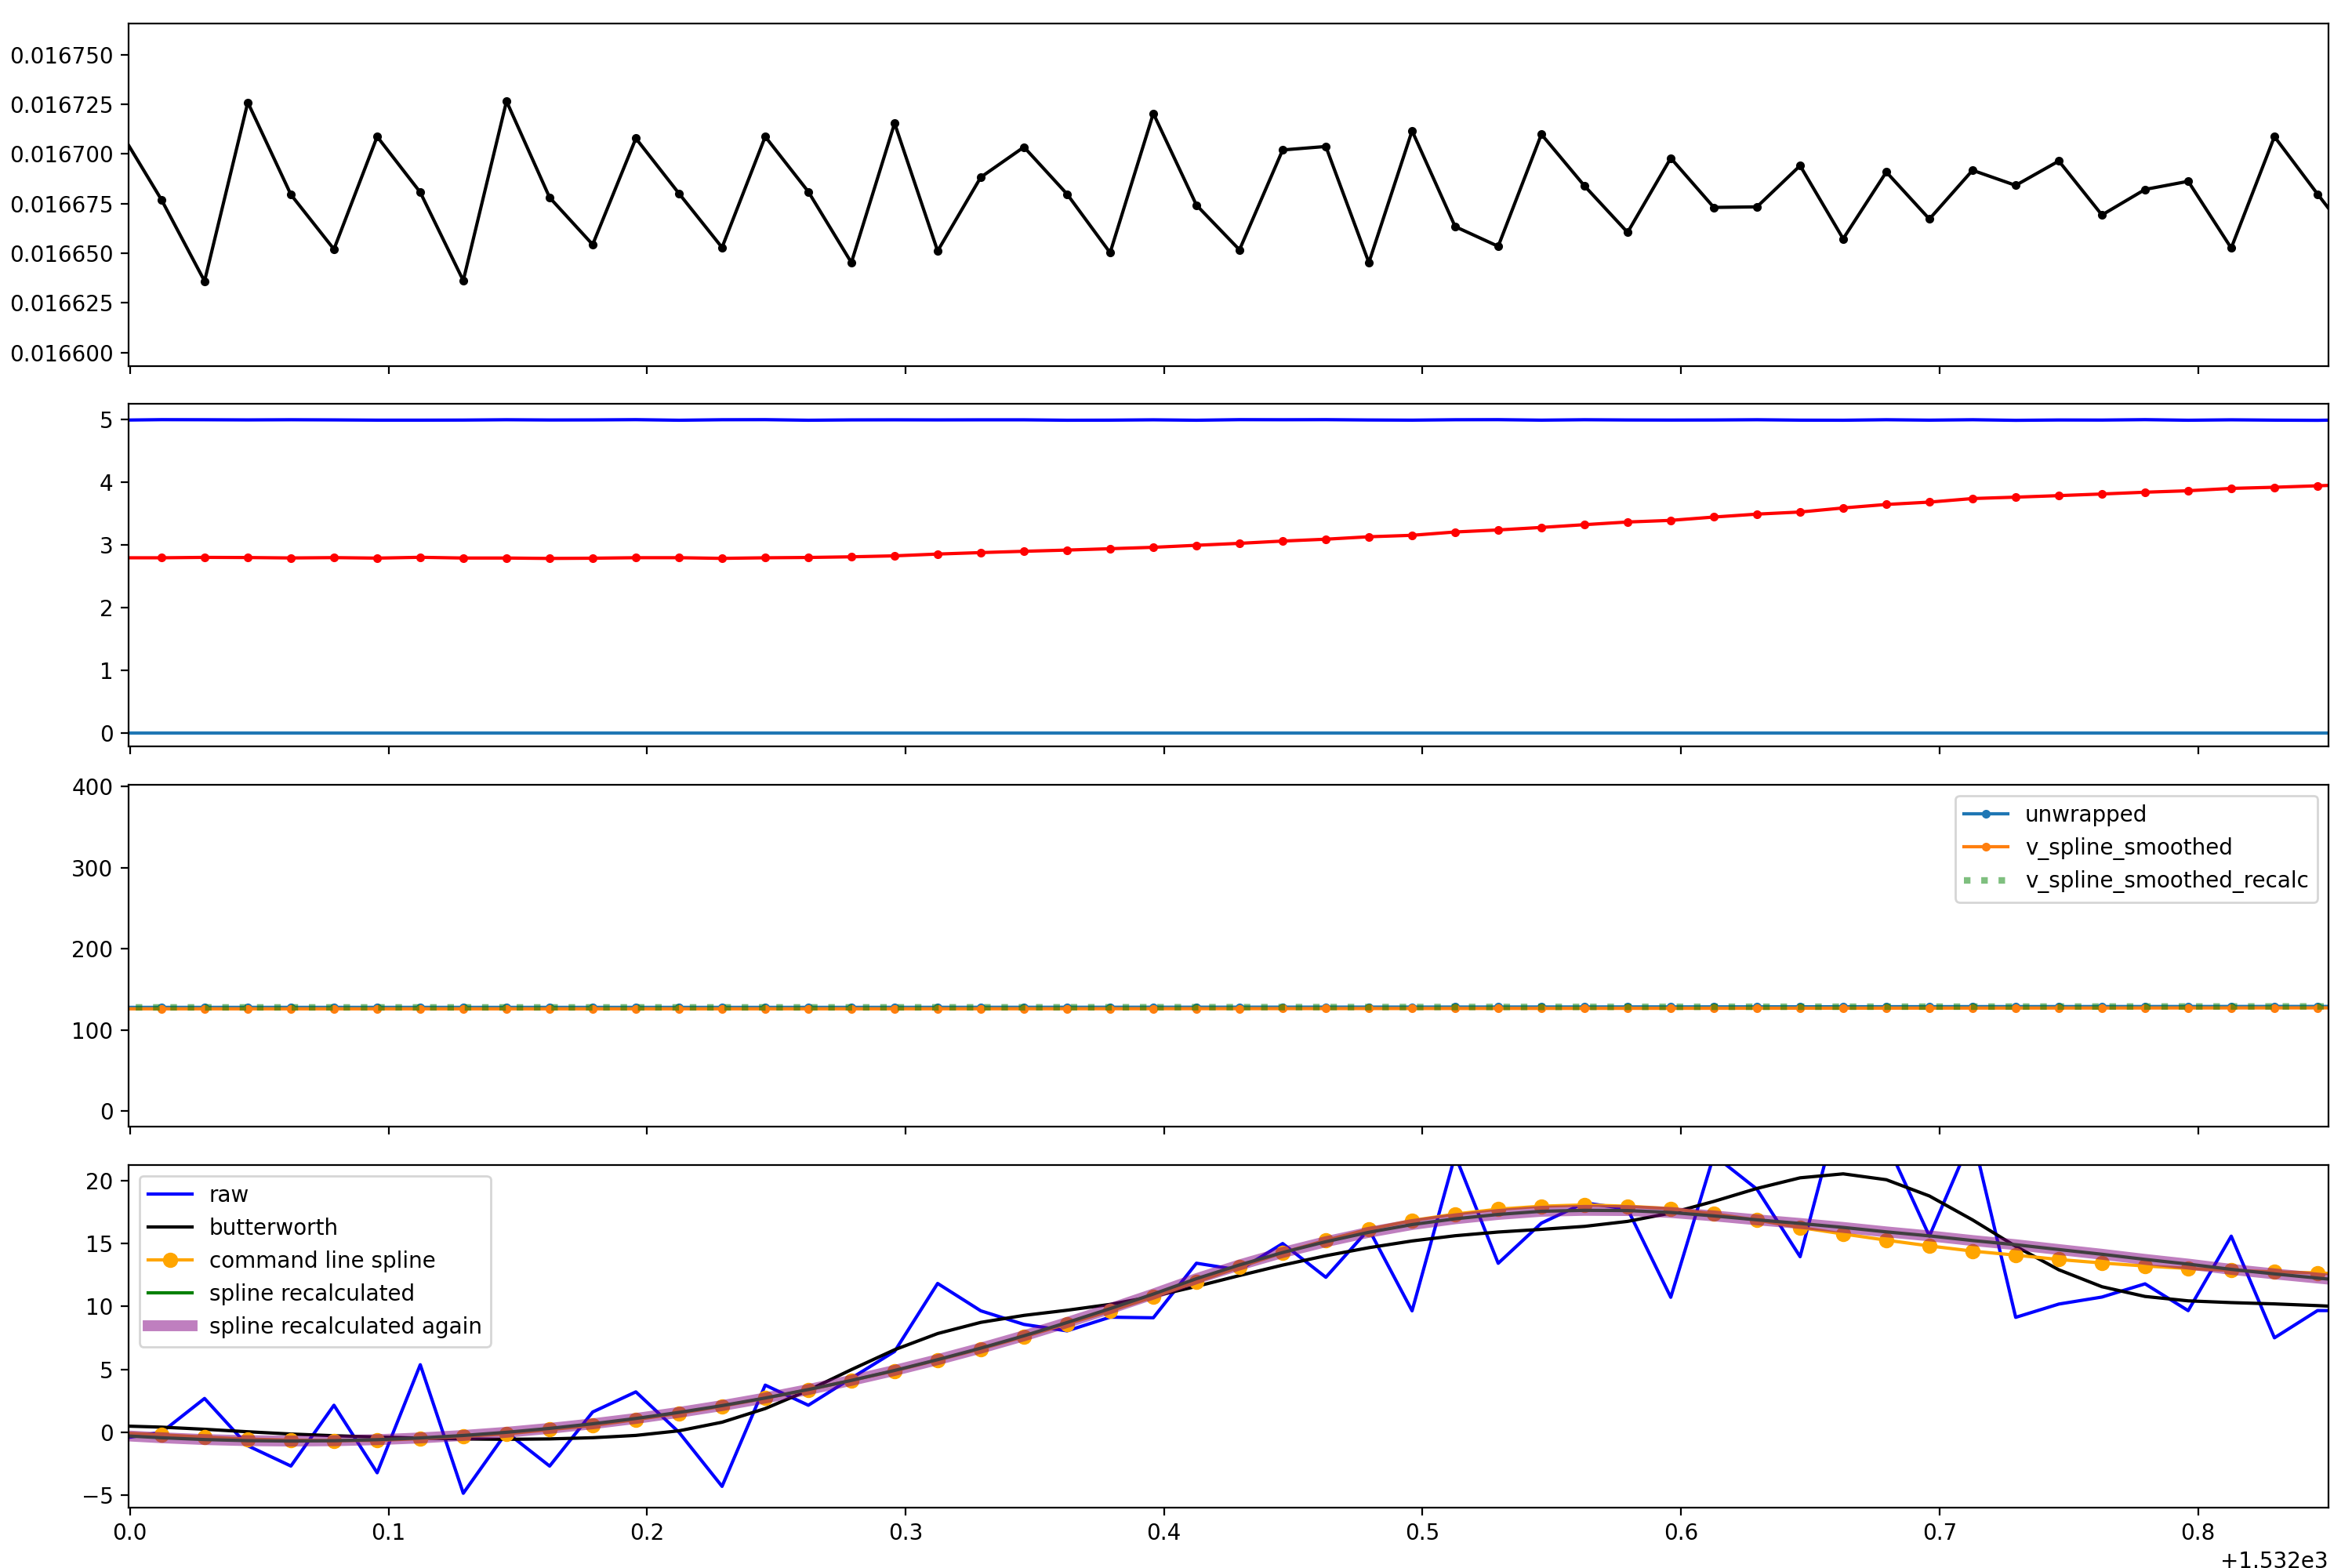

In [15]:
fig,ax = make_plot(dft)

ax[2].plot(
    df_sr['time'],
    df_sr['v_spline_smoothed_F={}_recalc'.format(n_knot_factor)],
    color='green',
    alpha=0.5,
    linewidth=3,
    linestyle=':'
)

ax[3].plot(
    df_sr['time'],
    df_sr['speed_spline_smoothed_F={}_recalc'.format(n_knot_factor)],
    color='green'
)

ax[3].plot(
    df_sr['time'],
    df_sr['speed_spline_smoothed_F=12'],
    color='purple',
    linewidth=5,
    alpha=0.5
)

ax[2].legend([
    'unwrapped',
    'v_spline_smoothed',
    'v_spline_smoothed_recalc'
])

ax[3].legend([
    'raw',
    'butterworth',
    'command line spline',
    'spline recalculated',
    'spline recalculated again'
])

# ax[3].set_xlim(1527.5,1528.5)

In [16]:
cached_df[cols_to_merge].query('time >=1527.8 and time <=1527.9')

,time,v_spline_smoothed_F=12,speed_spline_smoothed_F=12,acceleration_spline_smoothed_F=12,jerk_spline_smoothed_F=12
31642,1527.808708,2272.964549,12.899331,12.576241,96.467570
31643,1527.825387,2272.996202,13.157113,15.455294,172.613225
31644,1527.842043,2273.028354,13.387085,13.807304,-98.943878
31645,1527.858749,2273.061097,13.592683,12.307179,-89.797992
31646,1527.875429,2273.094131,13.726848,8.043411,-255.620076
31647,1527.892078,2273.127238,13.787199,3.624920,-265.394153


In [17]:
dft.query('time >=1527.8 and time <=1527.9')

,time,frame,speed,dx,v_sig,v_in,v_sig_last,wrap_ID,v_sig_diff,v_sig_unwrapped,speed_raw,wrap_bool,acceleration_raw,jerk_raw,speed_butterworth,v_spline_smoothed_F=12,speed_spline_smoothed_F=12,acceleration_spline_smoothed_F=12,jerk_spline_smoothed_F=12,v_spline_smoothed_F=12_recalc,speed_spline_smoothed_F=12_recalc
1667,1527.808708,91592,15.363427,2.747537,4.209679,4.992597,4.168337,0,0.041342,124.567395,17.118458,False,154.466905,-6365.142926,13.652317,2272.964549,12.899331,12.576241,96.467570,124.562077,12.973285
1668,1527.825387,91593,15.614905,2.366119,4.238102,4.987429,4.209679,0,0.028423,124.595818,11.814612,False,-317.991264,-28326.158298,14.092961,2272.996202,13.157113,15.455294,172.613225,124.594269,13.381600
1669,1527.842043,91594,16.194968,2.877621,4.276860,4.986137,4.238102,0,0.038758,124.634576,16.137655,False,259.551601,34675.154541,14.505598,2273.028354,13.387085,13.807304,-98.943878,124.627183,13.704138
1670,1527.858749,91595,16.557975,1.865571,4.302699,4.986137,4.276860,0,0.025839,124.660415,10.726406,False,-323.919259,-34926.768597,14.858376,2273.061097,13.592683,12.307179,-89.797992,124.660781,13.947426
1671,1527.875429,91596,16.696009,2.915695,4.345333,4.988721,4.302699,0,0.042634,124.703049,17.716396,False,419.061786,44542.972546,15.105182,2273.094131,13.726848,8.043411,-255.620076,124.694730,14.107488
1672,1527.892078,91597,16.955354,3.158622,4.387967,4.987429,4.345333,0,0.042634,124.745683,17.754307,False,2.277070,-25033.933520,15.187326,2273.127238,13.787199,3.624920,-265.394153,124.728835,14.202256
